In [1]:
import sys
print(sys.path)


['C:\\Users\\jedra\\Uni\\AI-Master\\Term-1\\Machine-Perception\\In-Bed_Human_Pose_Estimation\\src', 'C:\\Users\\jedra\\Uni\\AI-Master\\Term-1\\Machine-Perception\\In-Bed_Human_Pose_Estimation', 'C:\\Users\\jedra\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip', 'C:\\Users\\jedra\\AppData\\Local\\Programs\\Python\\Python311\\DLLs', 'C:\\Users\\jedra\\AppData\\Local\\Programs\\Python\\Python311\\Lib', 'C:\\Users\\jedra\\AppData\\Local\\Programs\\Python\\Python311', '', 'C:\\Users\\jedra\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\jedra\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\jedra\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\jedra\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'C:\\Users\\jedra\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages']


In [2]:
# ------------------------------------------------------------------------------
# The code is based on HigherHRNet-Human-Pose-Estimation.
# (https://github.com/HRNet/HigherHRNet-Human-Pose-Estimation)
# Further modified by Jędrzej Warczyński
# ------------------------------------------------------------------------------


import os

import matplotlib.pyplot as plt
from collections import namedtuple

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn.parallel
import torch.optim
import torch.utils.data
from torch.utils.data import DataLoader
import torch.utils.data.distributed
import torchvision.transforms
import torch.multiprocessing
from matplotlib import pyplot as plt
from dataset import HumanPoseDataset

from tqdm import tqdm

from lib import models as models

from src.lib.config import cfg
from src.lib.config import update_config
from src.lib.core.inference import get_multi_stage_outputs
from src.lib.core.inference import aggregate_results
from src.lib.core.nms import pose_nms
# from src.lib.core.match import match_pose_to_heatmap
# from dataset import make_test_dataloader
from src.lib.utils.utils import create_logger
from src.lib.utils.transforms import resize_align_multi_scale
from src.lib.utils.transforms import get_final_preds
from src.lib.utils.transforms import get_multi_scale_size

In [3]:
OPTS = ['TEST.MODEL_FILE', 'model/pose_crowdpose/pose_dekr_hrnetw32_crowdpose.pth', 'TEST.NMS_THRE', '0.15', 'TEST.SCALE_FACTOR', '0.5,1,2']
YAML_CFG = 'experiments/crowdpose/w32/w32_4x_reg03_bs10_512_adam_lr1e-3_crowdpose_x300.yaml'

args = namedtuple('args', ['cfg', 'opts'])
args.cfg = YAML_CFG
args.opts = OPTS

# print(os.getcwd())
update_config(cfg, args)

In [4]:
# cudnn related setting
cudnn.benchmark = cfg.CUDNN.BENCHMARK
torch.backends.cudnn.deterministic = cfg.CUDNN.DETERMINISTIC
torch.backends.cudnn.enabled = cfg.CUDNN.ENABLED

logger, final_output_dir, _ = create_logger(cfg, args.cfg, 'valid')

model = eval('models.'+cfg.MODEL.NAME+'.get_pose_net')(
    cfg, is_train=False
)

print(cfg.TEST.MODEL_FILE)
if cfg.TEST.MODEL_FILE:
    logger.info('=> loading model from {}'.format(cfg.TEST.MODEL_FILE))
    model.load_state_dict(torch.load(cfg.TEST.MODEL_FILE), strict=True)
else:
    model_state_file = os.path.join(
        final_output_dir, 'model_best.pth.tar'
    )
    logger.info('=> loading model from {}'.format(model_state_file))
    model.load_state_dict(torch.load(model_state_file))

model = torch.nn.DataParallel(model, device_ids=cfg.GPUS).cuda()
model.eval()

=> creating output\crowd_pose_kpt\hrnet_dekr\w32_4x_reg03_bs10_512_adam_lr1e-3_crowdpose_x300
=> creating log\crowd_pose_kpt\hrnet_dekr\w32_4x_reg03_bs10_512_adam_lr1e-3_crowdpose_x300_2024-04-24-12-40
model/pose_crowdpose/pose_dekr_hrnetw32_crowdpose.pth


INFO:root:=> loading model from model/pose_crowdpose/pose_dekr_hrnetw32_crowdpose.pth
=> loading model from model/pose_crowdpose/pose_dekr_hrnetw32_crowdpose.pth


DataParallel(
  (module): PoseHigherResolutionNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affin

In [5]:
ROOT = '../res/dataset/train/train/'
dataset = HumanPoseDataset(root_dir=ROOT, train=True, transform=None)
dataset.__len__()

1350

In [6]:
def infere(model, image, cfg):
    transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])
    with torch.no_grad():
        heatmap_sum = 0
        poses = []
        
        base_size, center, scale = get_multi_scale_size(
            image, cfg.DATASET.INPUT_SIZE, 1.0, 1.0
        )
    
        for scale in sorted(cfg.TEST.SCALE_FACTOR, reverse=True):
            # Resize the image
            image_resized, center, scale_resized = resize_align_multi_scale(
                image, cfg.DATASET.INPUT_SIZE, scale, 1.0
            )
            image_resized = transforms(image_resized)
            image_resized = image_resized.unsqueeze(0).cuda()
    
            # Get multi-stage outputs from the model
            heatmap, posemap = get_multi_stage_outputs(
                cfg, model, image_resized, cfg.TEST.FLIP_TEST
            )
    
            # Aggregate results
            heatmap_sum, poses = aggregate_results(
                cfg, heatmap_sum, poses, heatmap, posemap, scale
            )
    
        # Average the heatmaps
        heatmap_avg = heatmap_sum / len(cfg.TEST.SCALE_FACTOR)
    
        # Perform pose non-maximum suppression
        poses, scores = pose_nms(cfg, heatmap_avg, poses)
        pose = np.argmax(scores)
    
        # Get final predictions
        final_poses = get_final_preds(
            poses, center, scale_resized, base_size
        )
    
    return final_poses[pose]
    

In [7]:
def show_prediction(original_IR_img, skeleton):
    global _
    plt.imshow(original_IR_img)  # Display the original image
    for joint in skeleton:
        x, y, _ = joint
        plt.plot(x, y, 'ro')  # Plot each joint as a red dot
        plt.axis('off')
    plt.show()

In [8]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
data_iter = iter(dataloader)

C:\Users\jedra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\jedra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


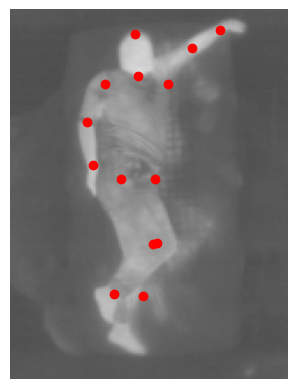

In [9]:
imgs, labels = next(data_iter)
original_IR_img = imgs.IR[0]
image = original_IR_img.cpu().numpy()

skeleton = infere(model, image, cfg)
show_prediction(original_IR_img, skeleton)